# 🏠 Use Case: Classification – Predicting “Luxury vs. Standard” Housing

## Step 1: Generate Synthetic Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
n_samples = 600

data_class = pd.DataFrame({
    "size_sqft": np.random.normal(1500, 400, n_samples),
    "num_rooms": np.random.randint(2, 8, n_samples),
    "age_years": np.random.randint(1, 50, n_samples),
    "location": np.random.choice(["urban", "suburban", "rural"], n_samples),
    "condition": np.random.choice(["poor", "average", "good"], n_samples),
    "price": np.random.normal(200000, 50000, n_samples)
})

# Target: Luxury if price > 220k
data_class["luxury"] = (data_class["price"] > 220000).astype(int)

# Introduce missing values
for col in ["size_sqft", "num_rooms", "age_years", "location", "condition"]:
    data_class.loc[data_class.sample(frac=0.1).index, col] = np.nan

X_class = data_class.drop(["luxury", "price"], axis=1)
y_class = data_class["luxury"]


In [16]:
data_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   size_sqft  540 non-null    float64
 1   num_rooms  540 non-null    float64
 2   age_years  540 non-null    float64
 3   location   540 non-null    object 
 4   condition  540 non-null    object 
 5   price      600 non-null    float64
 6   luxury     600 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 32.9+ KB


In [17]:
# Description de la base de données
data_class.describe(include="all")

,size_sqft,num_rooms,age_years,location,condition,price,luxury
count,540.000000,540.000000,540.000000,540,540,600.000000,600.000000
unique,NaN,NaN,NaN,3,3,NaN,NaN
top,NaN,NaN,NaN,suburban,poor,NaN,NaN
freq,NaN,NaN,NaN,188,198,NaN,NaN
mean,1493.209318,4.411111,24.851852,NaN,NaN,198706.727893,0.340000
std,389.086376,1.710349,14.078243,NaN,NaN,49495.499097,0.474104
min,203.493064,2.000000,1.000000,NaN,NaN,26428.505403,0.000000
25%,1216.264019,3.000000,12.000000,NaN,NaN,164359.544566,0.000000
50%,1493.848018,4.000000,25.000000,NaN,NaN,198905.576210,0.000000
75%,1750.534755,6.000000,37.000000,NaN,NaN,234178.191374,1.000000


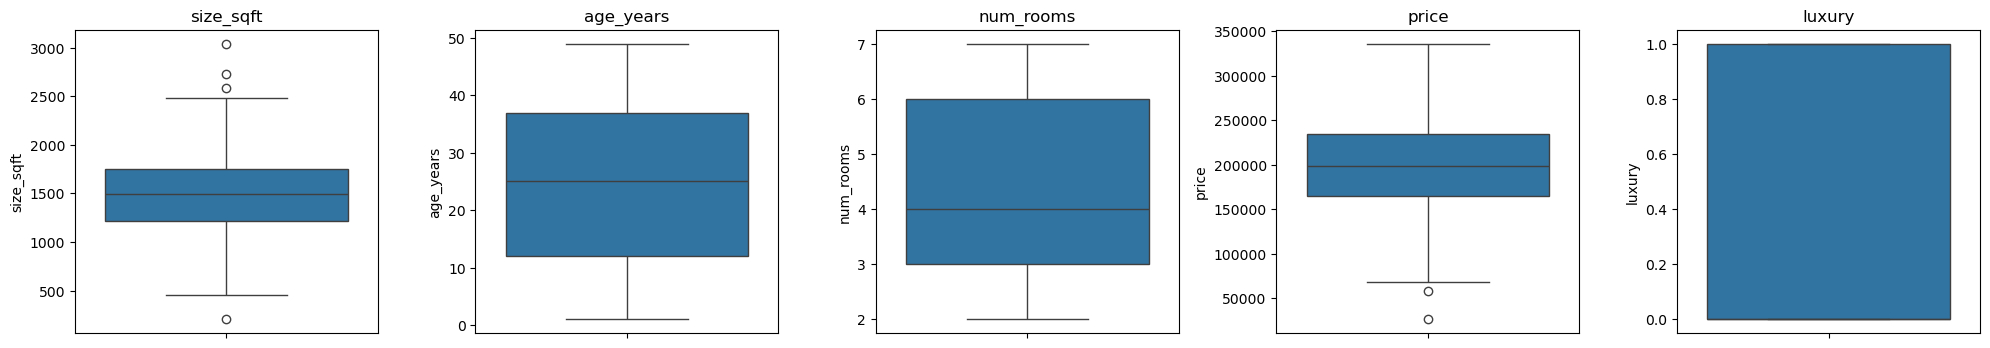

In [19]:

# Quantitative Variables to Display
quant_vars = ['size_sqft', 'age_years', 'num_rooms', 'price', 'luxury']

# Create figure
plt.figure(figsize=(20,10))

# Create a boxplot for each variable quantitative
for i, var in enumerate(quant_vars):
    plt.subplot(3, 5, i+1)
    sns.boxplot(data = data_class, y = var)
    plt.title(var)

# Afficher la figure
plt.tight_layout()
plt.show()

## Step 2: Pipeline + Models

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, stratify=y_class, random_state=42)

# Preprocessing
numeric_features = ["size_sqft", "num_rooms", "age_years"]
nominal_features = ["location"]
ordinal_features = ["condition"]

ordinal_mapping = [["poor", "average", "good"]]

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]), numeric_features),
    ("nom", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), nominal_features),
    ("ord", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ordenc", OrdinalEncoder(categories=ordinal_mapping))]), ordinal_features)
])

# Candidate models
models = {
    "logreg": LogisticRegression(max_iter=1000),
    "rf": RandomForestClassifier(),
    "gb": GradientBoostingClassifier(),
    "svm": SVC(probability=True),
    "knn": KNeighborsClassifier(),
    "dt": DecisionTreeClassifier()
}


## Step 3: GridSearch + Evaluation

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

results_class = {}
for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", model)])
    grid = GridSearchCV(pipe, param_grid={}, cv=5, scoring="roc_auc")  # simple grid
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:,1]
    results_class[name] = {
        "best_score": grid.best_score_,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "report": classification_report(y_test, y_pred)
    }

print(results_class["rf"])  # Example: Random Forest results


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'best_score': np.float64(0.47926880078050027), 'confusion_matrix': array([[96, 23],
       [48, 13]]), 'roc_auc': 0.5070257611241218, 'report': '              precision    recall  f1-score   support\n\n           0       0.67      0.81      0.73       119\n           1       0.36      0.21      0.27        61\n\n    accuracy                           0.61       180\n   macro avg       0.51      0.51      0.50       180\nweighted avg       0.56      0.61      0.57       180\n'}


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
